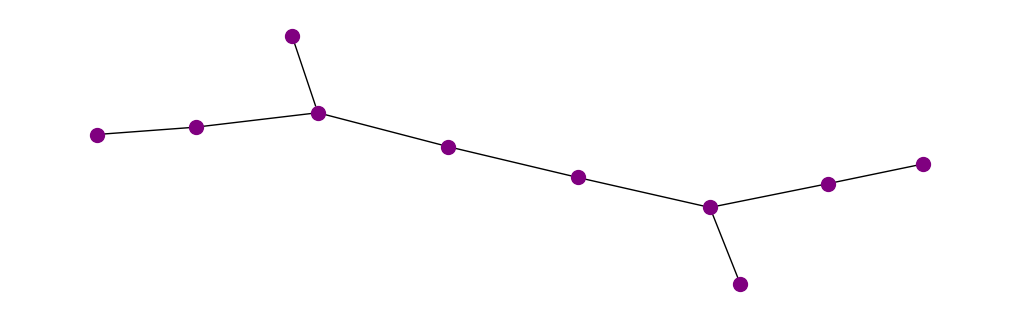

In [32]:
import subprocess
import pydot
import networkx as nx
import matplotlib.pyplot as plt

# Запускаем a.exe и ждем его завершения
subprocess.run(["a.exe"], check=True)

# Загружаем граф из файла в формате dot с помощью networkx и pydot
G = nx.nx_pydot.read_dot('tree.dot')

# Рисуем дерево
plt.figure(figsize=(10, 3))
nx.draw(G, with_labels=False, node_size=100, node_color='purple', font_size=5, font_weight='bold', edge_color='black')
plt.show()